In [8]:
import time
import os
import glob
import csv
import numpy as np
import pandas as pd
from scipy import stats
import openai
import matplotlib.pyplot as plt
import seaborn as sns

# File locations
dir = '/Users/Federica_1/Documents/GitHub/endoQAeval'
out_dir = os.path.join(dir, 'output')
fig_dir = os.path.join(dir, 'figures')

In [9]:
annotations = pd.read_csv(os.path.join(out_dir, 'all_annotations.csv'), index_col=0)
grouped = annotations.groupby(['question_id', 'question', 'response', 'response_id',
       'Prompt', 'Medical Concern', 'Annotator Type', 'Metric'], as_index=False).mean()
grouped[:1]

,question_id,question,response,response_id,Prompt,Medical Concern,Annotator Type,Metric,Annotator,Score
0,Endo_2xjk3k_post,I'm in the UK if that makes a difference! Basi...,weight management in patients with pcos (polyc...,endoR142,doc_prompt,Endometriosis,Patient,Actionability,2.5,2.0


# Statistical Testing of Difference in Information Quality, Empathy, and Actionability Ratings between Patients and Specialist

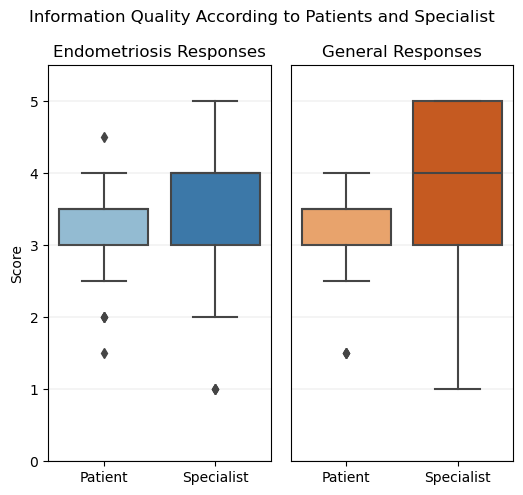

In [10]:
colors_concern = {'Endometriosis':{'Patient': sns.color_palette('Blues')[2], 'Specialist': sns.color_palette('Blues')[4]},
                  'General': {'Patient': sns.color_palette('Oranges')[2], 'Specialist': sns.color_palette('Oranges')[4]}}

figure = plt.figure(figsize = (16/3,5), tight_layout=0.5)
plt.suptitle(f'Performance for Endomentriosis Responses Across Prompting Strategies')
pos = 1

for concern in ['Endometriosis', 'General']:

    figure.add_subplot(1,2,pos)

    ax = sns.boxplot(data=grouped[(grouped['Prompt'] == 'no_prompt') &
                              (grouped['Metric'] == 'Information Quality') &
                              (grouped['Medical Concern'] == concern)],
                 x='Annotator Type', y="Score",
                 palette=colors_concern[concern])
    plt.ylim(0,5.5)
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_xlabel('')

    if pos == 2:
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(color='white')
        ax.set_yticklabels([])

    plt.title(f'{concern} Responses')
    pos += 1

plt.suptitle(f'Information Quality According to Patients and Specialist')
plt.savefig(os.path.join(fig_dir, f'patientvsspecialist.png'), dpi = 300, bbox_inches = "tight")


In [11]:
pat = pd.read_csv(os.path.join(out_dir, 'patient_annotations.csv'), usecols=range(4,13))
doc = pd.read_csv(os.path.join(out_dir, 'specialist_annotations.csv'), usecols=range(4,8))
merged = pd.merge(left=pat, left_on=['response_id', 'prompt', 'type'], right=doc, right_on=['response_id', 'prompt', 'type'])

for column in ["Information Quality","Empathy","Actionability"]:
    key = f'Average {column}'
    key2 = f'Annotator 2 - {column}'
    key3 = f'Annotator 3 - {column}'
    merged[key] = merged[[key2, key3]].mean(axis=1)
merged[:1]

,response_id,prompt,type,Annotator 2 - Information Quality,Annotator 2 - Empathy,Annotator 2 - Actionability,Annotator 3 - Information Quality,Annotator 3 - Empathy,Annotator 3 - Actionability,Specialist - Information Quality,Average Information Quality,Average Empathy,Average Actionability
0,endoR0,no_prompt,endo,4,2,2,3,2,2,4,3.5,2.0,2.0


## All answers

In [12]:
patient = merged['Average Information Quality'].values
specialist = merged['Specialist - Information Quality'].values
print(stats.mannwhitneyu(patient, specialist, alternative='two-sided'))
print(stats.wilcoxon(patient, specialist, alternative='two-sided'))

MannwhitneyuResult(statistic=59156.5, pvalue=1.074325412241145e-07)
WilcoxonResult(statistic=19541.0, pvalue=1.6965356579996817e-05)


## Endometriosis answers

In [13]:
patient = merged[(merged['type'] == 'endo')]['Average Information Quality'].values
specialist = merged[(merged['type'] == 'endo')]['Specialist - Information Quality'].values
print(stats.mannwhitneyu(patient, specialist, alternative='two-sided'))
print(stats.wilcoxon(patient, specialist, alternative='two-sided'))

MannwhitneyuResult(statistic=36673.5, pvalue=0.0039510956379857605)
WilcoxonResult(statistic=13022.0, pvalue=0.06194996064209626)


## General answers

In [14]:
patient = merged[(merged['type'] == 'general')]['Average Information Quality'].values
specialist = merged[(merged['type'] == 'general')]['Specialist - Information Quality'].values
print(stats.mannwhitneyu(patient, specialist, alternative='two-sided'))
print(stats.wilcoxon(patient, specialist, alternative='two-sided'))

MannwhitneyuResult(statistic=2571.5, pvalue=2.194286265914894e-08)
WilcoxonResult(statistic=617.0, pvalue=4.234652541553666e-07)


## Percentage

In [19]:
perc_info_d = {'Annotator':[], 'Score': [], 'Percentage':[]}
endo_info = merged[merged['type'] == 'endo'].copy()


for ann in ['Annotator 2', 'Annotator 3', 'Specialist']:
    # print(ann)
    for score in [1,2,3,4,5]:
        key = f'{ann} - Information Quality'
        perc = len(endo_info[endo_info[key] == score])/len(endo_info)*100
        perc_info_d['Annotator'].append(ann)
        perc_info_d['Score'].append(score)
        perc_info_d['Percentage'].append(perc)
        # print(perc)

In [16]:
perc_personas_df = pd.DataFrame.from_dict(perc_info_d)
perc_personas_df[:1]

,Annotator,Score,Percentage
0,Annotator 2,1,0.0


<Axes: xlabel='Score', ylabel='Percentage'>

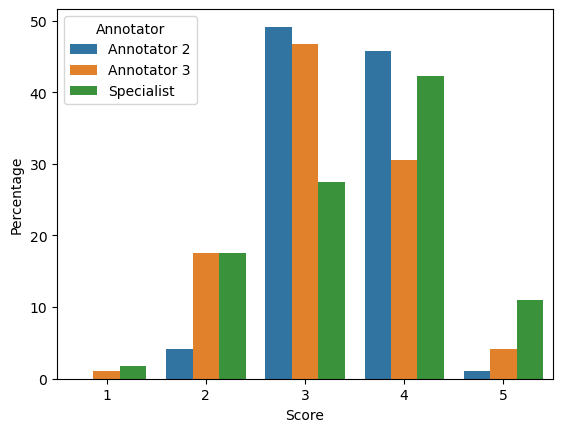

In [17]:
sns.barplot(data=perc_personas_df, x='Score', y='Percentage', hue='Annotator')


## Responses with score <1

In [ ]:
pd.set_option('display.max_colwidth', None)
grouped[(grouped['Annotator Type'] == 'Specialist') & (grouped['Score'] == 1)][['question', 'response']]